In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import xgboost
import sys
sys.path.append("./skynet/bf/src/scripts/")
import xgboost_ohlc
import utils
import numpy as np
import seaborn as sns
import talib
import datetime
import requests
import threading
from threading import Thread
import os
import websocket
import signal
import pybitflyer
import time
import dateutil.parser
%matplotlib inline

pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
pd.options.display.precision = 10


end_point = 'wss://ws.lightstream.bitflyer.com/json-rpc'

public_channels = ['lightning_executions_FX_BTC_JPY','lightning_board_snapshot_FX_BTC_JPY']
private_channels = ['child_order_events', 'parent_order_events']

In [123]:
one = pd.read_csv('skynet/bf/data/processed/min.csv')

In [78]:
five = pd.read_csv('skynet/bf/data/processed/min_five.csv')

In [2]:
hour = pd.read_csv('skynet/bf/data/processed/hour.csv')

In [3]:
hour = utils.shaping_ohlc(hour,['BBUpper','BBMiddle','BBLower','Close','BBOver','BBUnder'])

In [4]:
hour

,BBUpper,BBMiddle,BBLower,Close,BBOver,BBUnder
0,NaN,NaN,NaN,4.6460000000e+04,False,False
1,NaN,NaN,NaN,4.6458746269e+04,False,False
2,NaN,NaN,NaN,4.6448000000e+04,False,False
3,NaN,NaN,NaN,4.6437253731e+04,False,False
4,NaN,NaN,NaN,4.6426507463e+04,False,False
...,...,...,...,...,...,...
43188,1.4420014584e+06,1.4259984444e+06,1.4099954304e+06,1.4114530000e+06,False,False
43189,1.4422544998e+06,1.4244944444e+06,1.4067343891e+06,1.4135480000e+06,False,False
43190,1.4377439830e+06,1.4211806667e+06,1.4046173503e+06,1.4094750000e+06,False,False
43191,1.4340634788e+06,1.4191417778e+06,1.4042200767e+06,1.4141550000e+06,False,False


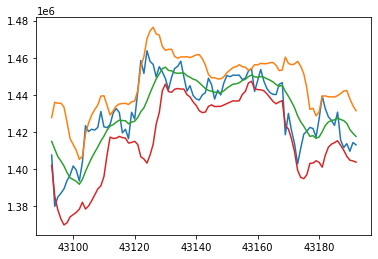

In [5]:
hour = hour[-100:]
plt.plot(hour['Close'])
plt.plot(hour['BBUpper'])
plt.plot(hour['BBMiddle'])
plt.plot(hour['BBLower'])

In [6]:
hour['BBOver'].mean()

0.04

In [190]:
class Bot(object):
    def __init__(self,balance=0.0,name=''):
        key = os.environ['API_KEY']
        secret = os.environ['API_SECRET']
        self.pbf = pybitflyer.API(api_key=key,api_secret=secret)
        self.side = 'no-position'
        self.positions = pd.DataFrame(columns=['price','size'])
        self.balance = balance
        self.income = 0
        self.child_orders = pd.DataFrame(columns=['child_order_id','expire_date','size','executed'])
        self.parent_orders = pd.DataFrame(columns=['parent_order_id'])
        self.child_acceptance_ids = []
        self.parent_acceptance_ids = []

        self.mid_price = 0
        self.bids = pd.DataFrame(columns = ['price','size'])
        self.asks = pd.DataFrame(columns = ['price','size'])

        #汎用 取引量抑えたりに使える
        self.cnt = 0

        self.name = name

    def market_buy(self,size,minutes_to_expire=43200,time_in_force="GTC"):
        result = self.pbf.sendchildorder(
          product_code='FX_BTC_JPY',
          child_order_type='MARKET',
          side='BUY',
          size=round(size,3),
          minutes_to_expire=minutes_to_expire,
          time_in_force=time_in_force
        )
        print(result)
        if type(result) == dict and 'child_order_acceptance_id' in result.keys():
            self.child_acceptance_ids.append(result['child_order_acceptance_id'])
        else:
            print("market_buy failed")
            print(result)

    def market_sell(self,size,minutes_to_expire=43200,time_in_force="GTC"):
        result = self.pbf.sendchildorder(
          product_code='FX_BTC_JPY',
          child_order_type='MARKET',
          side='SELL',
          size=round(size,3),
          minutes_to_expire=minutes_to_expire,
          time_in_force=time_in_force
        )
        print(result)
        if type(result) == dict and 'child_order_acceptance_id' in result.keys():
            self.child_acceptance_ids.append(result['child_order_acceptance_id'])
        else:
            print("market_sell failed")
            print(result)
            
    def limit_buy(self,price,size,minutes_to_expire=43200,time_in_force="GTC"):
        result = self.pbf.sendchildorder(
          product_code='FX_BTC_JPY',
          child_order_type='LIMIT',
          side='BUY',
          price=int(price),
          size=round(size,3),
          minutes_to_expire=minutes_to_expire,
          time_in_force=time_in_force
        )
        return result
        if type(result) == dict and 'child_order_acceptance_id' in result.keys():
            self.child_acceptance_ids.append(result['child_order_acceptance_id'])
        else:
            print("limit_buy failed")
            print(result)

    def limit_sell(self,price,size,minutes_to_expire=43200,time_in_force="GTC"):
        result = self.pbf.sendchildorder(
          product_code='FX_BTC_JPY',
          child_order_type='LIMIT',
          side='SELL',
          price=int(price),
          size=round(size,3),
          minutes_to_expire=minutes_to_expire,
          time_in_force=time_in_force
        )
        return result
        if type(result) == dict and 'child_order_acceptance_id' in result.keys():
            self.child_acceptance_ids.append(result['child_order_acceptance_id'])
        else:
            print("limit_sell failed")
            print(result)

bot = Bot()

In [27]:
bot.market_buy(size=0.01)
bot.market_sell(size=0.01)

{'child_order_acceptance_id': 'JRF20201031-143458-017111'}
{'child_order_acceptance_id': 'JRF20201031-143458-293558'}


In [ ]:
executions = pd.read_csv('skynet/bf/data/raw/executions.csv')
executions['exec_date'] = executions['exec_date'].apply(lambda x: dateutil.parser.parse(x).timestamp())
executions['exec_date_ceil'] = executions['exec_date'].apply(np.ceil).astype(int)
grouped = executions.groupby('exec_date_ceil')
seconds = pd.DataFrame()
seconds['timestamp'] = grouped['exec_date_ceil'].first()
seconds['Open'] = grouped['price'].first()
seconds['High'] = grouped['price'].max()
seconds['Low'] = grouped['price'].min()
seconds['Close'] = grouped['price'].last()
seconds = seconds.reset_index(drop=True)

seconds['Target_ConvergenceRate'] = 0
#どっちに先に到達しているかを確認するためのcode
for i in range(seconds.shape[0]-1):
    rate = 0
    base = seconds['Close'].values[i]
    upper = False
    lower = False
    flag = False
    cnt = 1
    while i+cnt <= seconds.shape[0]-1:
        if base*(1+rate) <= seconds['High'].values[i+cnt]:
            upper = True
            if base*(1+2*rate) <= seconds['High'].values[i+cnt]:
                break
                
        if seconds['Low'].values[i+cnt] <= base*(1-rate):
            lower = True
            if seconds['Low'].values[i+cnt] <= base*(1-2*rate):
                break
                
        if upper and lower:
            flag = True
            break
            
        cnt += 1
        
    seconds['Pure_Convergence'].values[i] = flag
    
seconds.to_csv('skynet/bf/data/processed/seconds.csv',index=False)

In [82]:
ts = pd.DataFrame()
for s in range(seconds['timestamp'].values[0],seconds['timestamp'].values[-1]-10):
    tmp = seconds[(s <= seconds['timestamp']) & (seconds['timestamp'] < s + 10)]
    if tmp.shape[0] >= 10:
        ts_mini = pd.Series(
            [
                tmp['timestamp'].values[-1],
                tmp['Open'].values[0],
                tmp['High'].max(),
                tmp['Low'].min(),
                tmp['Close'].values[-1]
            ],
            index=[
                'timestamp',
                'Open',
                'High',
                'Low',
                'Close'
            ]
        )
        ts = ts.append(ts_mini,ignore_index=True)

KeyboardInterrupt: 

In [190]:
seconds = pd.read_csv('skynet/bf/data/processed/seconds.csv')

In [192]:
seconds['Pure_Convergence'] = False

In [187]:
#どっちに先に到達しているかを確認するためのcode
rate = 0.00025
for i in range(seconds.shape[0]-1):
    base = seconds['Close'].values[i]
    upper = False
    lower = False
    flag = False
    cnt = 1
    while i+cnt <= seconds.shape[0]-1:
        if base*(1+rate) <= seconds['High'].values[i+cnt]:
            upper = True
            if base*(1+2*rate) <= seconds['High'].values[i+cnt]:
                break
                
        if seconds['Low'].values[i+cnt] <= base*(1-rate):
            lower = True
            if seconds['Low'].values[i+cnt] <= base*(1-2*rate):
                break
                
        if upper and lower:
            flag = True
            break
            
        cnt += 1
        
    seconds['Pure_Convergence'].values[i] = flag

In [154]:
seconds.to_csv('skynet/bf/data/processed/seconds.csv',index=False)

In [207]:
rate = 0.001
result = []
cnt2_li = []
for _ in range(20):
    rate += 0.00001
    for i in range(3000):
        base = seconds['Close'].values[i]
        upper = False
        lower = False
        flag = False
        cnt = 1
        cnt2 = 0
        while i+cnt <= seconds.shape[0]-1:
            if base*(1+rate) <= seconds['High'].values[i+cnt]:
                upper = True
                if base*(1+2*rate) <= seconds['High'].values[i+cnt]:
                    cnt2_li.append(cnt2)
                    break

            if seconds['Low'].values[i+cnt] <= base*(1-rate):
                lower = True
                if seconds['Low'].values[i+cnt] <= base*(1-2*rate):
                    cnt2_li.append(cnt2)
                    break

            if upper and lower:
                flag = True
                cnt2_li.append(cnt2)
                break

            cnt += 1
            cnt2 += 1

        seconds['Pure_Convergence'].values[i] = flag
    
    result.append(seconds['Pure_Convergence'][:3000].mean())

KeyboardInterrupt: 

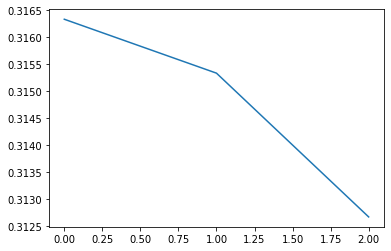

In [208]:
plt.plot(result)

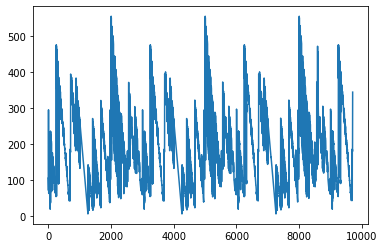

In [209]:
plt.plot(cnt2_li)

In [165]:
result

[0.296,
 0.348,
 0.293,
 0.237,
 0.151,
 0.1,
 0.113,
 0.187,
 0.285,
 0.332,
 0.464,
 0.658,
 0.874,
 0.911,
 0.891,
 0.827,
 0.784,
 0.715,
 0.69,
 0.669,
 0.668,
 0.717,
 0.828,
 0.945,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [164]:
result[-5:]

[1.0, 1.0, 1.0, 1.0, 1.0]

In [139]:
result[15:25]

[0.29, 0.291, 0.294, 0.292, 0.291, 0.291, 0.291, 0.298, 0.29, 0.296]

In [243]:
smoku = utils.shaping_ohlc(seconds,['Close']+['1moku-precedent-span1','1moku-precedent-span2','1moku-signal4','1moku-signal6','1moku-signal3','1moku-signal5'])

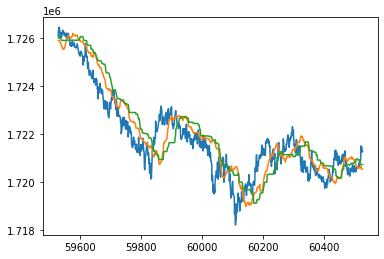

In [237]:
smoku = smoku[-1000:]
plt.plot(smoku['Close'])
plt.plot(smoku['1moku-precedent-span1'])
plt.plot(smoku['1moku-precedent-span2'])

In [249]:
state = 0
income = [0]
cnt = 0
for i in range(smoku.shape[0]):
    if smoku['1moku-signal3'].values[i] == 1 or smoku['1moku-signal5'].values[i] == -1:
        if state != 1:
            if state == -1:
                cnt += 1
                income.append(income[-1]-0.01*(value-smoku['Close'].values[i]))
            value = smoku['Close'].values[i]
            state = 1
        else:
            income.append(income[-1])
    elif smoku['1moku-signal5'].values[i] == 1 or smoku['1moku-signal3'].values[i] == -1:
        if state != -1:
            if state == 1:
                cnt += 1
                income.append(income[-1]+0.01*(value-smoku['Close'].values[i]))
            value = smoku['Close'].values[i]
            state = -1
        else:
            income.append(income[-1])
    else:
        income.append(income[-1])

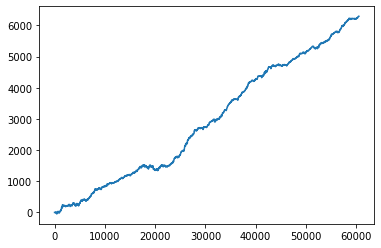

In [250]:
plt.plot(income)

In [252]:
smoku.shape

(60529, 7)

In [254]:
smoku['1moku-signal5'].value_counts()

 0.0    56600
-1.0     1964
 1.0     1964
Name: 1moku-signal5, dtype: int64

In [246]:
smoku['1moku-signal5'].values[:300]

array([nan,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
        0.,  0.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0